In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 21 18:41:31 2024

@author: youss
"""

import tensorflow as tf
from tensorflow import keras




import tensorflow as tf
from keras import layers, Model



# 1. Encoder
class Encoder(Model):
    def __init__(self, latent):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=layers.LeakyReLU(0.02), padding="same")  # 512×512
        self.conv2 = layers.Conv2D(64, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 256×256
        self.conv3 = layers.Conv2D(128, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 128×128
        self.conv4 = layers.Conv2D(256, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 64×64
        self.conv5 = layers.Conv2D(512, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 32×32
        self.conv6 = layers.Conv2D(512, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 16×16
        self.conv7 = layers.Conv2D(512, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 8×8
        self.conv8 = layers.Conv2D(512, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 4×4

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1024, activation="selu")
        self.mu = layers.Dense(latent)
        self.log_var = layers.Dense(latent)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.flatten(x)
        x = self.dense(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var


# 2. Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu))  # Sample from normal distribution
        return mu + tf.exp(0.5 * log_var) * epsilon


# 3. Decoder (modifié pour générer 512×512)
class Decoder(Model):
    def __init__(self, latent):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(1024, activation="selu")
        self.dense2 = layers.Dense(8192, activation="selu")
        self.reshape = layers.Reshape((4, 4, 512))

        self.deconv1 = layers.Conv2DTranspose(256, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")  # 8×8
        self.deconv2 = layers.Conv2DTranspose(128, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")  # 16×16
        self.deconv3 = layers.Conv2DTranspose(64, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")   # 32×32
        self.deconv4 = layers.Conv2DTranspose(32, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")   # 64×64
        self.deconv5 = layers.Conv2DTranspose(16, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")   # 128×128
        self.deconv6 = layers.Conv2DTranspose(8, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")    # 256×256
        self.deconv7 = layers.Conv2DTranspose(4, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")    # 512×512

        self.output_layer = layers.Conv2DTranspose(3, kernel_size=5, activation="sigmoid", padding="same")  # 512×512×3

    def call(self, z):
        x = self.dense1(z)
        x = self.dense2(x)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.deconv6(x)
        x = self.deconv7(x)
        return self.output_layer(x)


class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = self.sampling([mu, log_var])
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var



class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Adjust input shape to (64, 64, 3)
        self.conv2d1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3))
        self.leaky_relu1 = layers.LeakyReLU()
        self.dropout1 = layers.Dropout(0.3)

        self.conv2d2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu2 = layers.LeakyReLU()
        self.dropout2 = layers.Dropout(0.3)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation='sigmoid')  # Output single value for real/fake classification

    def call(self, inputs):
        x = self.conv2d1(inputs)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)
        x = self.conv2d2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x


In [25]:
class GAN:
    def __init__(self, latent):
        self.latent = latent

        #self.vae=VAE(encoder,decoder)
        self.discriminator = Discriminator()
        self.cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
        self.discriminator_optimizer = keras.optimizers.Adam(1e-4)
        self.generator_optimizer = keras.optimizers.Adam(1e-4)
        self.vae = VAE(Encoder(latent), Decoder(latent))


    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss


    # The generator_loss function should be indented to be part of the GAN class
    def generator_loss(self,fake_output, real_images, reconstructed_images, mu, log_var, lambda_recon=1, lambda_kl=0.1):
        # Perte adversariale : pousse le discriminateur à croire que les fausses images sont réelles
        adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

        # Perte de reconstruction (MSE ou BCE selon ton choix)
        # Ensure real_images and reconstructed_images have the same shape
        # real_images is actually the discriminator's output for real images,
        # so it's not what we need for the reconstruction loss.
        # Instead, we'll use the original images passed to train_step:

        real_images_for_reconstruction = tf.image.resize(real_images, (reconstructed_images.shape[1], reconstructed_images.shape[2]))
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(real_images_for_reconstruction - reconstructed_images), axis=[1, 2, 3]))

        # Perte KL pour régulariser l’espace latent
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)

        # Combinaison des pertes avec des coefficients de pondération
        return adversarial_loss + lambda_recon * reconstruction_loss + lambda_kl * kl_loss

In [72]:
import tensorflow as tf
from keras import layers, Model
from tensorflow import keras
# 1. Encoder
class Encoder(Model):
    def __init__(self, latent):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=layers.LeakyReLU(0.02), padding="same")  # 64×64
        self.conv2 = layers.Conv2D(64, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 32×32
        self.conv3 = layers.Conv2D(128, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 16×16
        self.conv4 = layers.Conv2D(256, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 8×8
        self.conv5 = layers.Conv2D(512, kernel_size=5, activation=layers.LeakyReLU(0.02), strides=2, padding="same")  # 4×4

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(512, activation="selu")  # Réduit la taille du vecteur latent
        self.mu = layers.Dense(latent)
        self.log_var = layers.Dense(latent)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.dense(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var


# 2. Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * epsilon


# 3. Decoder (modifié pour générer 64×64)
class Decoder(Model):
    def __init__(self, latent):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(512, activation="selu")
        self.dense2 = layers.Dense(8192, activation="selu")  # Correspond à (4,4,512)
        self.reshape = layers.Reshape((4, 4, 512))

        self.deconv1 = layers.Conv2DTranspose(256, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")  # 8×8
        self.deconv2 = layers.Conv2DTranspose(128, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")  # 16×16
        self.deconv3 = layers.Conv2DTranspose(64, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")   # 32×32
        self.deconv4 = layers.Conv2DTranspose(32, kernel_size=5, strides=2, activation=layers.LeakyReLU(0.02), padding="same")   # 64×64

        self.output_layer = layers.Conv2DTranspose(3, kernel_size=5, activation="sigmoid", padding="same")  # 64×64×3

    def call(self, z):
        x = self.dense1(z)
        x = self.dense2(x)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        return self.output_layer(x)


# 4. VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = self.sampling([mu, log_var])
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var


# 5. Discriminator (adapté à 64x64)
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv2d1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3))
        self.leaky_relu1 = layers.LeakyReLU()
        self.dropout1 = layers.Dropout(0.3)

        self.conv2d2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu2 = layers.LeakyReLU()
        self.dropout2 = layers.Dropout(0.3)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv2d1(inputs)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)
        x = self.conv2d2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x


# 6. GAN
class GAN:
    def __init__(self, latent):
        self.latent = latent

        self.discriminator = Discriminator()
        self.cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
        self.discriminator_optimizer = keras.optimizers.Adam(1e-4)
        self.generator_optimizer = keras.optimizers.Adam(1e-4)
        self.vae = VAE(Encoder(latent), Decoder(latent))

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output, real_images, reconstructed_images, mu, log_var, lambda_recon=1, lambda_kl=0.1):
        adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

        real_images_for_reconstruction = tf.image.resize(real_images, (reconstructed_images.shape[1], reconstructed_images.shape[2]))
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(real_images_for_reconstruction - reconstructed_images), axis=[1, 2, 3]))

        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)

        return adversarial_loss + lambda_recon * reconstruction_loss + lambda_kl * kl_loss


In [73]:

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')


# Chemin du fichier ZIP dans Google Drive
zip_path = '/content/drive/MyDrive/casting_512x512.zip'

# Répertoire de destination pour décompresser les fichiers
extract_path = '/content/casting_512x512'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:

# Décompresser le fichier
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Fichiers extraits dans : {extract_path}")






Fichiers extraits dans : /content/casting_512x512


In [75]:

# Chemin vers le dossier des images extraites
image_dir = r'/content/casting_512x512/casting_512x512/ok_front'

# Charger les images depuis le dossier
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]



519


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


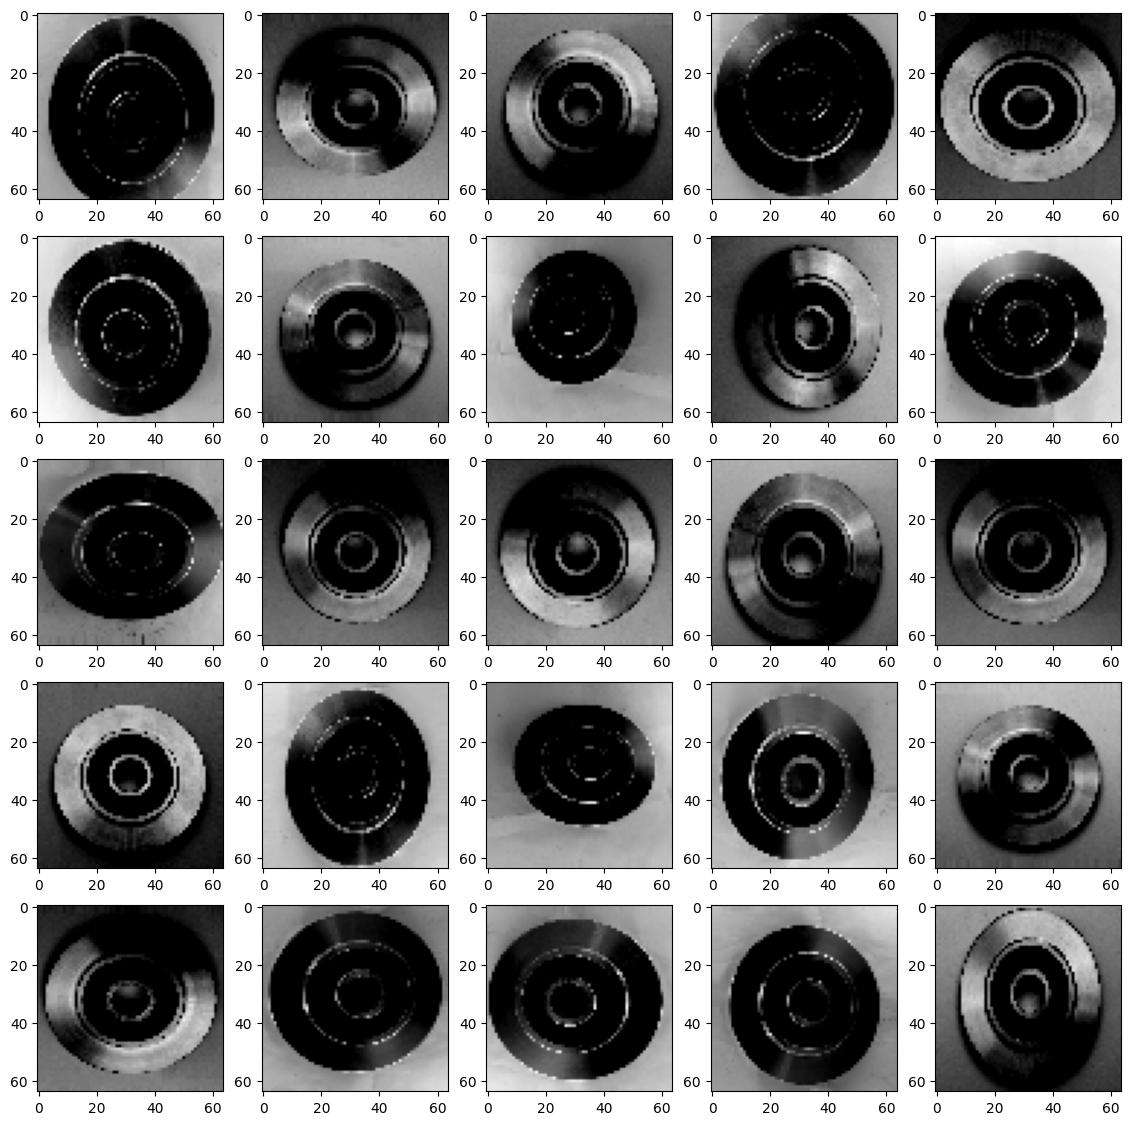

In [76]:
# Afficher les 6 premières images
images[:6]



def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

batch_size = 32

training_dataset = tf.data.Dataset.from_tensor_slices((images)) #Si images contient les chemins d'accès : alors le Dataset résultant contiendra seulement les chemins des fichiers

print(len(training_dataset))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(900).batch(batch_size)

len(training_dataset)


# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])#imshow peut détecter que les valeurs des pixels sont entre 0 et 1 (au lieu de 0 et 255) et ajuste l'affichage pour montrer les images correctement
        idx+=1



latent_dim = 100

epochs = 500
gan = GAN(latent_dim)

#@tf.function
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure the output directory exists
output_dir = '/content/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Your existing train_step and train functions remain the same

In [9]:
sample_batch = next(iter(training_dataset))
print("Batch type:", type(sample_batch))

Batch type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [9]:
sample_batch.shape

TensorShape([128, 64, 64, 3])

In [77]:
def train_step(images,gan1):

    # Train discriminator
    with tf.GradientTape() as disc_tape:

        reconstructed , mu, log_var=gan1.vae(images,training=True)
        real_output = gan1.discriminator(images, training=True)
        fake_output = gan1.discriminator(reconstructed, training=True)
        disc_loss = gan1.discriminator_loss(real_output, fake_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, gan1.discriminator.trainable_variables)
        gan1.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, gan1.discriminator.trainable_variables))

    # Train generator
    with tf.GradientTape() as gen_tape:
        reconstructed, mu, log_var=gan1.vae(images,training=True)
        fake_output = gan1.discriminator(reconstructed, training=True)
        # real_output is not needed in generator_loss anymore
        gen_loss = gan1.generator_loss(fake_output,images,reconstructed,mu, log_var)  # Pass 'images' instead of 'real_output'
        gradients_of_generator = gen_tape.gradient(gen_loss, gan1.vae.trainable_variables)
        gan1.generator_optimizer.apply_gradients(zip(gradients_of_generator, gan1.vae.trainable_variables))


    return disc_loss, gen_loss


In [78]:


# Utilisation de listes au lieu de np.array pour éviter l'erreur de .append()
disc_error = []
gen_error = []

def train(dataset, epochs, gan1):
    for epoch in range(epochs):
        disc_tot = 0.0  # Réinitialisation des accumulateurs à chaque époque
        gen_tot = 0.0

        for image_batch in dataset:
            disc_loss, gen_loss = train_step(image_batch, gan1)
            disc_tot += disc_loss.numpy()
            gen_tot += gen_loss.numpy()

        # Calcul de la moyenne des erreurs pour l'époque
        disc_mean = disc_tot / len(dataset)
        gen_mean = gen_tot / len(dataset)

        # Stockage des erreurs
        disc_error.append(disc_mean)
        gen_error.append(gen_mean)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_mean}, Disc Loss: {disc_mean}')

        # Génération et sauvegarde d'images
        random_vector = tf.random.normal(shape=(25, latent_dim))
        generate_and_save_images(gan1.vae.decoder, epoch + 1, random_vector)


def generate_and_save_images(model, epoch, test_input, output_dir="output_images"):
    os.makedirs(output_dir, exist_ok=True)  # Création du dossier si inexistant
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        image = (predictions[i, :, :, 0] + 1) / 2  # Normalisation entre 0 et 1
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        # Sauvegarde de chaque image individuellement
        image_path = os.path.join(output_dir, f'epoch_{epoch:04d}_image_{i+1:02d}.png')
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
        plt.close()


In [ ]:

# Call the training function
train(training_dataset, epochs,gan)



/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Gen Loss: 4008.9596880744484, Disc Loss: 0.6362119790385751
Epoch 2, Gen Loss: 2320.123707490809, Disc Loss: 0.3942872859975871
Epoch 3, Gen Loss: 2092.364186006434, Disc Loss: 0.034443262800136036
Epoch 4, Gen Loss: 2066.5612003102024, Disc Loss: 0.006631932454183698
Epoch 5, Gen Loss: 2039.5557789522059, Disc Loss: 0.0040801368133329295
Epoch 6, Gen Loss: 1987.45461138557, Disc Loss: 0.0033870475976180065
Epoch 7, Gen Loss: 1881.922944910386, Disc Loss: 0.0022835447863840007
Epoch 8, Gen Loss: 1824.0790225758271, Disc Loss: 0.0015619889257804437
Epoch 9, Gen Loss: 1758.328405043658, Disc Loss: 0.0016206897904767709
Epoch 10, Gen Loss: 1698.3336540670955, Disc Loss: 0.0012904016424299164
Epoch 11, Gen Loss: 1642.4758372587316, Disc Loss: 0.0010933287369826919
Epoch 12, Gen Loss: 1595.5056439568016, Disc Loss: 0.0009358280855367946
Epoch 13, Gen Loss: 1556.0051915785846, Disc Loss: 0.0008689142602687592
Epoch 14, Gen Loss: 1524.5511330997242, Disc Loss: 0.000751634782371933
Ep

In [15]:
gan.vae.encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (32, 64, 64, 32)            │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 32, 32, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 16, 16, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 8, 8, 256)             │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 4, 4, 512)             │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 8192)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 512)                   │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 100)                   │          51,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 100)                   │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,652,808 (33.01 MB)

 Trainable params: 8,652,808 (33.01 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
gan.vae.decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (32, 512)                   │          51,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 8192)                  │       4,202,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (32, 4, 4, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (32, 8, 8, 256)             │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (32, 16, 16, 128)           │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (32, 32, 32, 64)            │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (32, 64, 64, 32)            │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (32, 64, 64, 3)             │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,609,091 (32.84 MB)

 Trainable params: 8,609,091 (32.84 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
gan.discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 32, 32, 64)            │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 16, 16, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 32768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1)                     │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

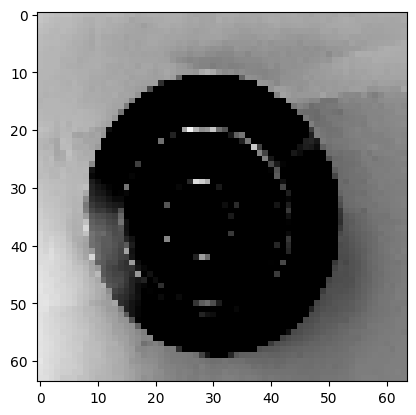

In [49]:
test_image_path = images[0]  # Use the first image for testing
test_image = preprocess(test_image_path)
test_image = tf.expand_dims(test_image, axis=0)  # Add batch dimension
plt.imshow(test_image[0])
discriminator_output = gan.discriminator(test_image, training=False)

In [50]:
discriminator_output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [51]:
dummy_input = tf.random.normal(shape=(1, 64, 64, 3))
image_gener,_,_ =gan.vae(dummy_input)

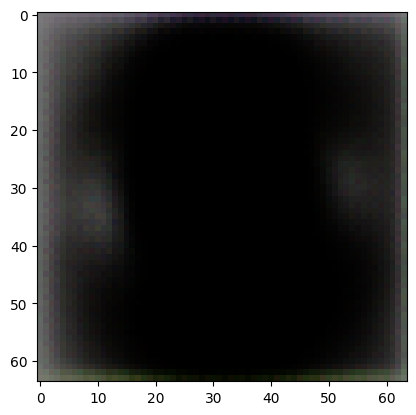

In [53]:
plt.imshow(image_gener[0])

In [52]:
gan.discriminator(image_gener)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.09154627]], dtype=float32)>

In [55]:
# Chemin vers le dossier des images extraites
image_dir_def = r'/content/casting_512x512/casting_512x512/def_front'

# Charger les images depuis le dossier
images_def = [os.path.join(image_dir_def, image) for image in os.listdir(image_dir_def)]

781


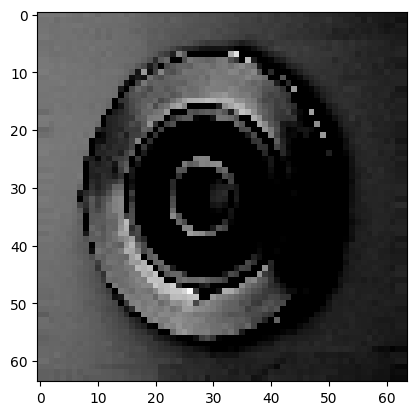

In [67]:
training_dataset = tf.data.Dataset.from_tensor_slices((images_def)) #Si images contient les chemins d'accès : alors le Dataset résultant contiendra seulement les chemins des fichiers

print(len(training_dataset))
training_dataset = training_dataset.map(preprocess)
test_image_def = next(iter(training_dataset.take(2)))
len(training_dataset)
test_image_def = tf.expand_dims(test_image_def, axis=0)  # Add batch dimension
plt.imshow(test_image_def[0])

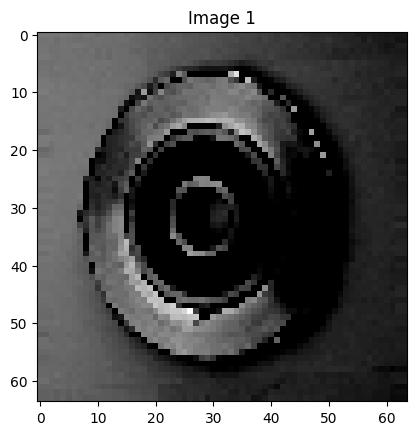

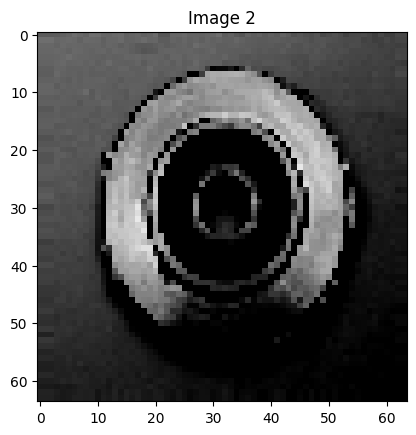

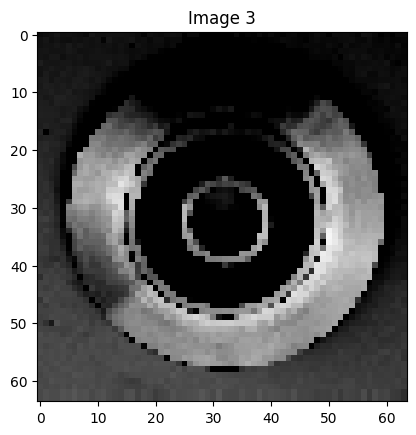

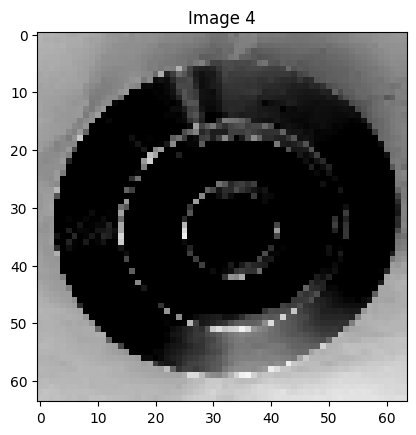

In [69]:
test_dataset = training_dataset.take(4)
for i, image in enumerate(test_dataset): # Iterate through each image
    plt.figure() # Create a new figure for each image
    plt.imshow(image)
    plt.title(f"Image {i+1}") # Add a title to identify the images
    plt.show()

Discriminator output for image 1: [[1.]]


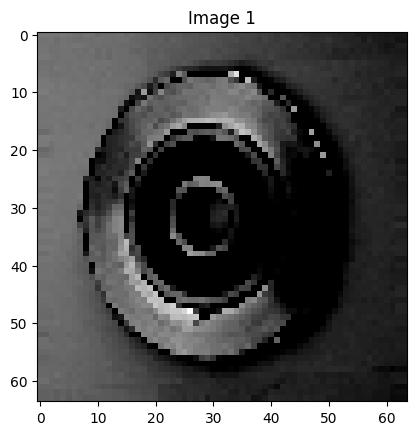

Discriminator output for image 2: [[0.9999995]]


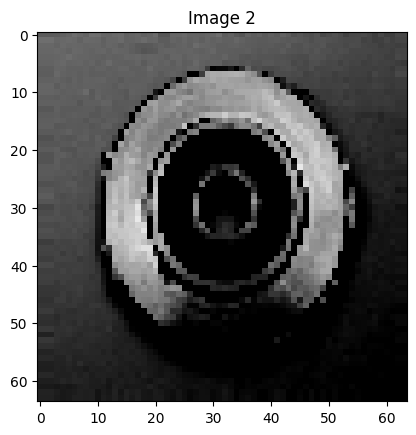

Discriminator output for image 3: [[1.]]


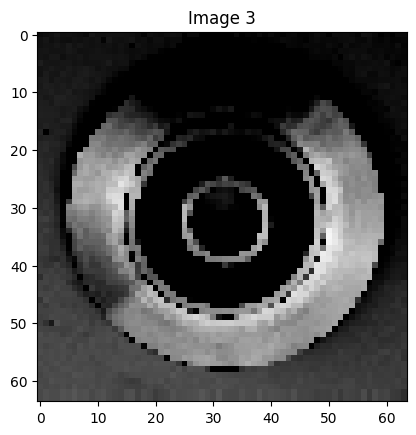

Discriminator output for image 4: [[1.]]


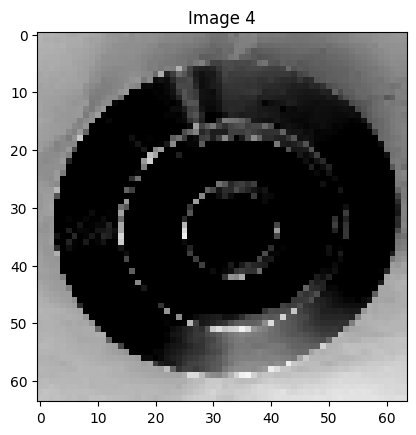

In [70]:
for i, image in enumerate(test_dataset): # Iterate through each image
    image = tf.expand_dims(image, axis=0) # Add batch dimension
    discriminator_output = gan.discriminator(image) # Pass single image to discriminator
    print(f"Discriminator output for image {i+1}: {discriminator_output}")
    plt.figure() # Create a new figure for each image
    plt.imshow(image[0])
    plt.title(f"Image {i+1}") # Add a title to identify the images
    plt.show()

In [60]:
gan.discriminator(test_image_def)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [4]:
def plot_losses(gen_error, disc_error):
    epochs = range(1, len(gen_error) + 1)  # Création de la liste des époques

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, gen_error, label="Perte du Générateur", marker='o', linestyle='-')
    plt.plot(epochs, disc_error, label="Perte du Discriminateur", marker='s', linestyle='-')

    plt.xlabel("Époque")
    plt.ylabel("Erreur")
    plt.title("Évolution de la perte en fonction des époques")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'appel (une fois que tu as rempli disc_error et gen_error avec le training)
plot_losses(gen_error, disc_error)

NameError: name 'gen_error' is not defined

In [ ]:
gan.discriminator(dataset, training=False)

In [3]:
import shutil
import os

source_folder = "/content/output_images"
destination_folder = "/content/drive/My Drive/output_images_colab"

# Créer le dossier de destination s'il n'existe pas
os.makedirs(destination_folder, exist_ok=True)

# Copier tous les fichiers
for file_name in os.listdir(source_folder):
    full_file_name = os.path.join(source_folder, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, destination_folder)

print("Copie terminée !")

Copie terminée !


In [1]:
import re

data = """
Epoch 1, Gen Loss: 3586.5565544577207, Disc Loss: 0.8559610668350669
Epoch 2, Gen Loss: 2189.3188548368566, Disc Loss: 0.2864744961261749
Epoch 3, Gen Loss: 2082.4706169577207, Disc Loss: 0.024218310492441934
Epoch 4, Gen Loss: 2071.5965935202207, Disc Loss: 0.0050553429652662836
Epoch 5, Gen Loss: 2050.013556985294, Disc Loss: 0.003365532125291579
Epoch 6, Gen Loss: 1983.2141831341912, Disc Loss: 0.0032177571453811493
Epoch 7, Gen Loss: 1870.8485466452205, Disc Loss: 0.0021565090385539565
Epoch 8, Gen Loss: 1803.6611399931066, Disc Loss: 0.0018339202232549295
Epoch 9, Gen Loss: 1751.5349623736213, Disc Loss: 0.0017443285392159049
Epoch 10, Gen Loss: 1697.7940099379596, Disc Loss: 0.0015251713133800555
Epoch 11, Gen Loss: 1641.2520967371324, Disc Loss: 0.0010568483626497362
Epoch 12, Gen Loss: 1581.3185604319854, Disc Loss: 0.0010514019454336341
Epoch 13, Gen Loss: 1534.6941205193016, Disc Loss: 0.0008060969309607411
Epoch 14, Gen Loss: 1515.2128188189338, Disc Loss: 0.0006939704933970728
Epoch 15, Gen Loss: 1500.6325970818016, Disc Loss: 0.0007088438946726348
Epoch 16, Gen Loss: 1487.4663516773896, Disc Loss: 0.0005461711005088599
Epoch 17, Gen Loss: 1477.9274256089154, Disc Loss: 0.0005143697190386079
Epoch 18, Gen Loss: 1469.815580480239, Disc Loss: 0.0004840291529784308
Epoch 19, Gen Loss: 1475.8946389590992, Disc Loss: 0.00045766839963000487
Epoch 20, Gen Loss: 1465.0643741383271, Disc Loss: 0.0003829676951521405
Epoch 21, Gen Loss: 1457.4855238970588, Disc Loss: 0.00037428842744488707
Epoch 22, Gen Loss: 1453.708740234375, Disc Loss: 0.0003087291817577994
Epoch 23, Gen Loss: 1452.2355813419117, Disc Loss: 0.000312400448926971
Epoch 24, Gen Loss: 1451.6970861098346, Disc Loss: 0.00030072681735927127
Epoch 25, Gen Loss: 1450.570010914522, Disc Loss: 0.00024967293874771497
Epoch 26, Gen Loss: 1440.0223388671875, Disc Loss: 0.00024503834977033823
Epoch 27, Gen Loss: 1436.3586353975184, Disc Loss: 0.00022385582697632557
Epoch 28, Gen Loss: 1433.517578125, Disc Loss: 0.0002019906635670101
Epoch 29, Gen Loss: 1423.5933694278492, Disc Loss: 0.00021015340462327003
Epoch 30, Gen Loss: 1426.657937442555, Disc Loss: 0.00022360474994296536
Epoch 31, Gen Loss: 1421.790247300092, Disc Loss: 0.0001661728208145017
Epoch 32, Gen Loss: 1423.1293155445771, Disc Loss: 0.00016215210373903734
Epoch 33, Gen Loss: 1417.6015696806066, Disc Loss: 0.00015854056469192181
Epoch 34, Gen Loss: 1415.214168772978, Disc Loss: 0.0001473511397574946
Epoch 35, Gen Loss: 1410.675515567555, Disc Loss: 0.00015861342570347274
Epoch 36, Gen Loss: 1412.6082691865809, Disc Loss: 0.00013489898714503986
Epoch 37, Gen Loss: 1403.6352251838234, Disc Loss: 0.00012532397244392675
Epoch 38, Gen Loss: 1410.3330508961396, Disc Loss: 0.00012471617874860598
Epoch 39, Gen Loss: 1396.1317928538604, Disc Loss: 0.00010854357178151772
Epoch 40, Gen Loss: 1408.2282858455883, Disc Loss: 0.00011094728688476607
Epoch 41, Gen Loss: 1391.5750014361213, Disc Loss: 0.00010222365209997138
Epoch 42, Gen Loss: 1393.3571059283088, Disc Loss: 0.00010095617343562052
Epoch 43, Gen Loss: 1392.0091337316176, Disc Loss: 9.205351007575005e-05
Epoch 44, Gen Loss: 1399.0878475413604, Disc Loss: 8.896062076126006e-05
Epoch 45, Gen Loss: 1388.779562557445, Disc Loss: 8.407064267564291e-05
Epoch 46, Gen Loss: 1386.2996969784008, Disc Loss: 0.0001250752511088435
Epoch 47, Gen Loss: 1385.6091452205883, Disc Loss: 7.185437602054342e-05
Epoch 48, Gen Loss: 1382.3850384880516, Disc Loss: 8.421351263035937e-05
Epoch 49, Gen Loss: 1375.8110782398896, Disc Loss: 7.007330821258674e-05
Epoch 50, Gen Loss: 1376.616548426011, Disc Loss: 6.773874081452104e-05
Epoch 51, Gen Loss: 1373.782190659467, Disc Loss: 6.29576641265029e-05
Epoch 52, Gen Loss: 1374.035120346967, Disc Loss: 8.0401793906383e-05
Epoch 53, Gen Loss: 1371.7832533892463, Disc Loss: 6.310102799034212e-05
Epoch 54, Gen Loss: 1374.561279296875, Disc Loss: 5.896626969522057e-05
Epoch 55, Gen Loss: 1368.5592400045955, Disc Loss: 5.3740094004109886e-05
Epoch 56, Gen Loss: 1374.8348245059742, Disc Loss: 5.5773993902702764e-05
Epoch 57, Gen Loss: 1363.5101246553309, Disc Loss: 5.002846308557577e-05
Epoch 58, Gen Loss: 1369.3948543772979, Disc Loss: 4.971097383959739e-05
Epoch 59, Gen Loss: 1369.3845932904412, Disc Loss: 4.7295024962616427e-05
Epoch 60, Gen Loss: 1372.9091007008271, Disc Loss: 4.518699043889201e-05
Epoch 61, Gen Loss: 1362.7290828929229, Disc Loss: 4.630757963669192e-05
Epoch 62, Gen Loss: 1367.7280129825367, Disc Loss: 4.439382160746711e-05
Epoch 63, Gen Loss: 1369.522683536305, Disc Loss: 4.489949113870834e-05
Epoch 64, Gen Loss: 1357.700475356158, Disc Loss: 3.850507156290833e-05
Epoch 65, Gen Loss: 1357.9580796185662, Disc Loss: 3.6125353022618906e-05
Epoch 66, Gen Loss: 1364.3870634191176, Disc Loss: 4.076670120412018e-05
Epoch 67, Gen Loss: 1356.0897432215074, Disc Loss: 3.6484638204616635e-05
Epoch 68, Gen Loss: 1359.7225485409008, Disc Loss: 3.481697058305144e-05
Epoch 69, Gen Loss: 1360.1331069048713, Disc Loss: 4.290017525764757e-05
Epoch 70, Gen Loss: 1350.0787497127758, Disc Loss: 3.360678684818113e-05
Epoch 71, Gen Loss: 1349.793026194853, Disc Loss: 4.2160726372779155e-05
Epoch 72, Gen Loss: 1358.0240550321691, Disc Loss: 3.299323201217168e-05
Epoch 73, Gen Loss: 1350.732701918658, Disc Loss: 2.7687987606922808e-05
Epoch 74, Gen Loss: 1349.5789651309742, Disc Loss: 3.001555481151787e-05
Epoch 75, Gen Loss: 1361.121768727022, Disc Loss: 3.193848501456052e-05
Epoch 76, Gen Loss: 1352.3548440372242, Disc Loss: 2.754083074892953e-05
Epoch 77, Gen Loss: 1351.8132970473346, Disc Loss: 2.8592638339914093e-05
Epoch 78, Gen Loss: 1351.835226619945, Disc Loss: 2.7332278210344477e-05
Epoch 79, Gen Loss: 1346.13720703125, Disc Loss: 2.6182946278234286e-05
Epoch 80, Gen Loss: 1350.6114286534926, Disc Loss: 2.667726734858554e-05
Epoch 81, Gen Loss: 1353.0106703814338, Disc Loss: 2.882950427781051e-05
Epoch 82, Gen Loss: 1350.415132410386, Disc Loss: 2.709940086146269e-05
Epoch 83, Gen Loss: 1351.5448931525734, Disc Loss: 2.414115811809418e-05
Epoch 84, Gen Loss: 1347.6029196346508, Disc Loss: 2.5245534369091995e-05
Epoch 85, Gen Loss: 1343.3444106158088, Disc Loss: 2.2845806891863877e-05
Epoch 86, Gen Loss: 1340.1027760225184, Disc Loss: 2.2468483273448382e-05
Epoch 87, Gen Loss: 1341.2459214154412, Disc Loss: 2.210344342422425e-05
Epoch 88, Gen Loss: 1335.8570125804229, Disc Loss: 2.0914839912139168e-05
Epoch 89, Gen Loss: 1333.5937571806066, Disc Loss: 2.017008339006519e-05
Epoch 90, Gen Loss: 1336.2200137867646, Disc Loss: 1.9313350950302693e-05
Epoch 91, Gen Loss: 1337.0553768382354, Disc Loss: 1.7706902781355893e-05
Epoch 92, Gen Loss: 1345.0930965647979, Disc Loss: 1.7283122494571964e-05
Epoch 93, Gen Loss: 1339.114164464614, Disc Loss: 1.847711524426225e-05
Epoch 94, Gen Loss: 1333.9177964154412, Disc Loss: 2.2716898135566973e-05
Epoch 95, Gen Loss: 1331.8922190946691, Disc Loss: 2.1617728955735563e-05
Epoch 96, Gen Loss: 1331.7048411649816, Disc Loss: 1.61982420783769e-05
Epoch 97, Gen Loss: 1334.7501723345588, Disc Loss: 1.670384699536953e-05
Epoch 98, Gen Loss: 1337.5248305376838, Disc Loss: 1.7689912510832073e-05
Epoch 99, Gen Loss: 1333.1965978285846, Disc Loss: 1.513491403837928e-05
Epoch 100, Gen Loss: 1329.549768784467, Disc Loss: 1.4672559272559524e-05
Epoch 101, Gen Loss: 1324.5632467830883, Disc Loss: 1.4939773925160647e-05
Epoch 102, Gen Loss: 1328.9712416704963, Disc Loss: 1.5528172057469527e-05
Epoch 103, Gen Loss: 1325.2280417049633, Disc Loss: 1.5250114248534801e-05
Epoch 104, Gen Loss: 1322.6051958869484, Disc Loss: 1.60355270428922e-05
Epoch 105, Gen Loss: 1333.3414450252758, Disc Loss: 1.447087596020805e-05
Epoch 106, Gen Loss: 1325.24462890625, Disc Loss: 1.3570080067010541e-05
Epoch 107, Gen Loss: 1328.0071088005516, Disc Loss: 1.3889592915294248e-05
Epoch 108, Gen Loss: 1324.9813304227941, Disc Loss: 1.3455170948659275e-05
Epoch 109, Gen Loss: 1327.5648408777574, Disc Loss: 1.2781015387270814e-05
Epoch 110, Gen Loss: 1326.4145220588234, Disc Loss: 1.3091579977994757e-05
Epoch 111, Gen Loss: 1318.715597713695, Disc Loss: 1.2682657661437534e-05
Epoch 112, Gen Loss: 1325.4225284352021, Disc Loss: 1.2345195326655384e-05
Epoch 113, Gen Loss: 1318.0038775275734, Disc Loss: 1.0580282725962152e-05
Epoch 114, Gen Loss: 1321.8626565372242, Disc Loss: 1.0823739959211225e-05
Epoch 115, Gen Loss: 1329.0581700942096, Disc Loss: 1.220203165864993e-05
Epoch 116, Gen Loss: 1319.0485696231617, Disc Loss: 1.1147862377423307e-05
Epoch 117, Gen Loss: 1317.3839111328125, Disc Loss: 1.0832020856643045e-05
Epoch 118, Gen Loss: 1321.0119916130516, Disc Loss: 1.0901600396263188e-05
Epoch 119, Gen Loss: 1314.717062557445, Disc Loss: 9.907286496132548e-06
Epoch 120, Gen Loss: 1311.575834386489, Disc Loss: 1.0004760925392689e-05
Epoch 121, Gen Loss: 1321.0999181410846, Disc Loss: 9.881681147389291e-06
Epoch 122, Gen Loss: 1318.1334587545955, Disc Loss: 1.1179064586031018e-05
Epoch 123, Gen Loss: 1323.8483096852021, Disc Loss: 9.812118150875904e-06
Epoch 124, Gen Loss: 1312.9272891773896, Disc Loss: 9.710585017915838e-06
Epoch 125, Gen Loss: 1315.280050838695, Disc Loss: 9.106365282337612e-06
Epoch 126, Gen Loss: 1313.3980497472426, Disc Loss: 8.79775777374401e-06
Epoch 127, Gen Loss: 1316.4097541360295, Disc Loss: 9.514317806700573e-06
Epoch 128, Gen Loss: 1305.5156680836396, Disc Loss: 8.858334414232077e-06
Epoch 129, Gen Loss: 1305.5002369600184, Disc Loss: 8.629520145993464e-06
Epoch 130, Gen Loss: 1309.0486988740809, Disc Loss: 8.316388349318432e-06
Epoch 131, Gen Loss: 1314.7038502412684, Disc Loss: 9.287411865657572e-06
Epoch 132, Gen Loss: 1312.0283921185662, Disc Loss: 8.653576608540949e-06
Epoch 133, Gen Loss: 1308.1328771254596, Disc Loss: 8.095871354431866e-06
Epoch 134, Gen Loss: 1307.5347325942096, Disc Loss: 8.103576018423637e-06
Epoch 135, Gen Loss: 1308.0860667509191, Disc Loss: 7.362208226796236e-06
Epoch 136, Gen Loss: 1300.3148696001838, Disc Loss: 8.248051619161475e-06
Epoch 137, Gen Loss: 1307.0737591911766, Disc Loss: 7.553984827983881e-06
Epoch 138, Gen Loss: 1306.7265122357537, Disc Loss: 7.730091109645882e-06
Epoch 139, Gen Loss: 1305.3608685661766, Disc Loss: 6.992493487867999e-06
Epoch 140, Gen Loss: 1299.208438648897, Disc Loss: 7.305938772654318e-06
Epoch 141, Gen Loss: 1303.7700626148896, Disc Loss: 7.150323373185957e-06
Epoch 142, Gen Loss: 1298.596945369945, Disc Loss: 6.826528733771444e-06
Epoch 143, Gen Loss: 1302.2550838694854, Disc Loss: 6.407947680867544e-06
Epoch 144, Gen Loss: 1301.1426283892463, Disc Loss: 6.596060539804432e-06
Epoch 145, Gen Loss: 1298.0126522288604, Disc Loss: 8.988281037732924e-06
Epoch 146, Gen Loss: 1300.55226763557, Disc Loss: 6.530651526592171e-06
Epoch 147, Gen Loss: 1306.545187557445, Disc Loss: 6.553691378030635e-06
Epoch 148, Gen Loss: 1304.5203282973346, Disc Loss: 6.460668106121696e-06
Epoch 149, Gen Loss: 1303.7178237017463, Disc Loss: 6.535389281773806e-06
Epoch 150, Gen Loss: 1304.6626120174633, Disc Loss: 6.094083416615724e-06
Epoch 151, Gen Loss: 1302.1085923138787, Disc Loss: 7.182908869735376e-06
Epoch 152, Gen Loss: 1301.2842299517463, Disc Loss: 6.437476191850317e-06
Epoch 153, Gen Loss: 1304.758114085478, Disc Loss: 6.076863308087067e-06
Epoch 154, Gen Loss: 1304.0955666934742, Disc Loss: 5.948861779442643e-06
Epoch 155, Gen Loss: 1300.8914435891545, Disc Loss: 5.912380041028134e-06
Epoch 156, Gen Loss: 1304.677037856158, Disc Loss: 5.844443615601717e-06
Epoch 157, Gen Loss: 1300.1750775505516, Disc Loss: 5.6523153007754655e-06
Epoch 158, Gen Loss: 1295.698278090533, Disc Loss: 5.899639638621866e-06
Epoch 159, Gen Loss: 1303.1413646024816, Disc Loss: 5.2055035653478736e-06
Epoch 160, Gen Loss: 1301.2328096277574, Disc Loss: 5.912593043349796e-06
Epoch 161, Gen Loss: 1304.450439453125, Disc Loss: 5.616358414365951e-06
Epoch 162, Gen Loss: 1300.619930491728, Disc Loss: 5.536621328621336e-06
Epoch 163, Gen Loss: 1298.9544318704045, Disc Loss: 4.999339914908941e-06
Epoch 164, Gen Loss: 1294.6278866038604, Disc Loss: 5.09405332556579e-06
Epoch 165, Gen Loss: 1297.8208079618566, Disc Loss: 5.772504430430726e-06
Epoch 166, Gen Loss: 1300.96728515625, Disc Loss: 5.237778191927004e-06
Epoch 167, Gen Loss: 1295.5612505744484, Disc Loss: 5.310396485423125e-06
Epoch 168, Gen Loss: 1295.8251522288604, Disc Loss: 6.203130871707638e-06
Epoch 169, Gen Loss: 1291.6873348460479, Disc Loss: 4.890794242589222e-06
Epoch 170, Gen Loss: 1295.5650706571691, Disc Loss: 4.864045502686435e-06
Epoch 171, Gen Loss: 1296.3389318129596, Disc Loss: 4.709210369422662e-06
Epoch 172, Gen Loss: 1296.5559369255516, Disc Loss: 4.665354982963061e-06
Epoch 173, Gen Loss: 1291.62795122932, Disc Loss: 4.330402017625174e-06
Epoch 174, Gen Loss: 1298.7114904067096, Disc Loss: 4.252555195407962e-06
Epoch 175, Gen Loss: 1297.370023839614, Disc Loss: 4.40850023404196e-06
Epoch 176, Gen Loss: 1300.2498204848346, Disc Loss: 4.546057632925273e-06
Epoch 177, Gen Loss: 1296.566126206342, Disc Loss: 4.328110288256807e-06
Epoch 178, Gen Loss: 1302.8686595243566, Disc Loss: 4.741498093394244e-06
Epoch 179, Gen Loss: 1299.169132008272, Disc Loss: 4.0446788770007995e-06
Epoch 180, Gen Loss: 1296.5411951401654, Disc Loss: 4.459605928358917e-06
Epoch 181, Gen Loss: 1294.6158447265625, Disc Loss: 4.1790341824440365e-06
Epoch 182, Gen Loss: 1293.5987477022059, Disc Loss: 4.848409770709302e-06
Epoch 183, Gen Loss: 1290.9483139935662, Disc Loss: 4.011152996367052e-06
Epoch 184, Gen Loss: 1289.2810848460479, Disc Loss: 4.041005483489859e-06
Epoch 185, Gen Loss: 1294.4808565027574, Disc Loss: 3.686905622945393e-06
Epoch 186, Gen Loss: 1286.400972254136, Disc Loss: 3.918401887403888e-06
Epoch 187, Gen Loss: 1289.3133975758271, Disc Loss: 3.6736292038179217e-06
Epoch 188, Gen Loss: 1287.2985911649816, Disc Loss: 3.760018895558032e-06
Epoch 189, Gen Loss: 1294.3793514476104, Disc Loss: 3.5626736990600286e-06
Epoch 190, Gen Loss: 1295.71828326057, Disc Loss: 4.1902008781428726e-06
Epoch 191, Gen Loss: 1291.2949146943934, Disc Loss: 3.5447185984380397e-06
Epoch 192, Gen Loss: 1291.9218678193934, Disc Loss: 3.842258883972082e-06
Epoch 193, Gen Loss: 1292.0727251838234, Disc Loss: 3.5248122739015824e-06
Epoch 194, Gen Loss: 1299.0894057329963, Disc Loss: 3.1960262142948683e-06
Epoch 195, Gen Loss: 1295.9990162568934, Disc Loss: 3.3950142357539065e-06
Epoch 196, Gen Loss: 1300.5204647288604, Disc Loss: 3.7147594799962997e-06
Epoch 197, Gen Loss: 1293.6826961741729, Disc Loss: 3.6164617340011104e-06
Epoch 198, Gen Loss: 1285.3893324908088, Disc Loss: 3.175433386773233e-06
Epoch 199, Gen Loss: 1293.46144732307, Disc Loss: 3.502591579597399e-06
Epoch 200, Gen Loss: 1282.0713752297795, Disc Loss: 3.1568989162919664e-06
Epoch 201, Gen Loss: 1287.6881534352021, Disc Loss: 3.0567622856966304e-06
Epoch 202, Gen Loss: 1281.89259966682, Disc Loss: 2.915821397664331e-06
Epoch 203, Gen Loss: 1286.9917063993566, Disc Loss: 3.236985030659579e-06
Epoch 204, Gen Loss: 1280.0243350758271, Disc Loss: 2.929781527761995e-06
Epoch 205, Gen Loss: 1287.9533763212316, Disc Loss: 3.20323121125993e-06
Epoch 206, Gen Loss: 1281.8362534466912, Disc Loss: 3.555188079510973e-06
Epoch 207, Gen Loss: 1288.2151166130516, Disc Loss: 2.824908619913913e-06
Epoch 208, Gen Loss: 1285.5650778377758, Disc Loss: 2.8399455198482698e-06
Epoch 209, Gen Loss: 1288.366268382353, Disc Loss: 2.8041355068018995e-06
Epoch 210, Gen Loss: 1282.7453182444854, Disc Loss: 2.702676291602636e-06
Epoch 211, Gen Loss: 1288.4400491153492, Disc Loss: 2.9903276032093665e-06
Epoch 212, Gen Loss: 1283.7279483570771, Disc Loss: 2.676643759133078e-06
Epoch 213, Gen Loss: 1288.3431181066176, Disc Loss: 2.6462414072291132e-06
Epoch 214, Gen Loss: 1284.9863999310662, Disc Loss: 3.115962315672839e-06
Epoch 215, Gen Loss: 1282.0645895565258, Disc Loss: 2.5316347940882704e-06
Epoch 216, Gen Loss: 1281.4821705537684, Disc Loss: 2.478664443368175e-06
Epoch 217, Gen Loss: 1280.847017176011, Disc Loss: 2.6077484913939235e-06
Epoch 218, Gen Loss: 1291.6946662454045, Disc Loss: 2.4929137025002787e-06
Epoch 219, Gen Loss: 1285.3846220128676, Disc Loss: 2.393273069187404e-06
Epoch 220, Gen Loss: 1278.5956959443934, Disc Loss: 2.387449825391741e-06
Epoch 221, Gen Loss: 1277.7141903147979, Disc Loss: 2.5359611266353837e-06
Epoch 222, Gen Loss: 1276.891544117647, Disc Loss: 2.4699390772130915e-06
Epoch 223, Gen Loss: 1276.349666819853, Disc Loss: 2.2431807150603752e-06
Epoch 224, Gen Loss: 1282.8726303998162, Disc Loss: 2.323367535903826e-06
Epoch 225, Gen Loss: 1282.9294361787684, Disc Loss: 2.1470495969357646e-06
Epoch 226, Gen Loss: 1278.5671889361213, Disc Loss: 2.1983457794008515e-06
Epoch 227, Gen Loss: 1281.5234805836396, Disc Loss: 2.325736799695519e-06
Epoch 228, Gen Loss: 1278.7873391544117, Disc Loss: 2.169684703169557e-06
Epoch 229, Gen Loss: 1281.9395895565258, Disc Loss: 2.0980361023917154e-06
Epoch 230, Gen Loss: 1282.594877355239, Disc Loss: 2.2084922360430508e-06
Epoch 231, Gen Loss: 1275.8399155560662, Disc Loss: 2.0182714609638744e-06
Epoch 232, Gen Loss: 1278.9947294347426, Disc Loss: 2.150575775605081e-06
Epoch 233, Gen Loss: 1274.303430893842, Disc Loss: 2.121254470587112e-06
Epoch 234, Gen Loss: 1286.6394186580883, Disc Loss: 2.032260215066665e-06
Epoch 235, Gen Loss: 1282.2851849724266, Disc Loss: 2.0427595472938265e-06
Epoch 236, Gen Loss: 1275.9288904526654, Disc Loss: 2.0143062095164223e-06
Epoch 237, Gen Loss: 1278.7673483455883, Disc Loss: 2.074964637653038e-06
Epoch 238, Gen Loss: 1278.1134966681984, Disc Loss: 2.080729229071628e-06
Epoch 239, Gen Loss: 1282.4724049287684, Disc Loss: 1.9325206541425894e-06
Epoch 240, Gen Loss: 1281.528040268842, Disc Loss: 2.1751791454040788e-06
Epoch 241, Gen Loss: 1286.617223403033, Disc Loss: 2.080778589221582e-06
Epoch 242, Gen Loss: 1278.4473302504596, Disc Loss: 1.91722833415711e-06
Epoch 243, Gen Loss: 1276.8528693704045, Disc Loss: 1.8912135314006746e-06
Epoch 244, Gen Loss: 1279.1786247702205, Disc Loss: 1.871130213176537e-06
Epoch 245, Gen Loss: 1281.2105138442096, Disc Loss: 2.0204766462270257e-06
Epoch 246, Gen Loss: 1276.8367848115809, Disc Loss: 1.6583731595808196e-06
Epoch 247, Gen Loss: 1281.2045467601104, Disc Loss: 2.045427315940341e-06
Epoch 248, Gen Loss: 1280.2446145450367, Disc Loss: 1.8539576825894663e-06
Epoch 249, Gen Loss: 1276.5978716681984, Disc Loss: 1.7438857719967285e-06
Epoch 250, Gen Loss: 1273.7669534122242, Disc Loss: 1.7981664454429632e-06
Epoch 251, Gen Loss: 1273.2123951631434, Disc Loss: 1.5997474464601215e-06
Epoch 252, Gen Loss: 1272.2821188534008, Disc Loss: 2.0647326834932755e-06
Epoch 253, Gen Loss: 1281.3429673138787, Disc Loss: 1.6790353423429599e-06
Epoch 254, Gen Loss: 1274.7481545840992, Disc Loss: 1.5433518302308905e-06
Epoch 255, Gen Loss: 1270.2910012637867, Disc Loss: 1.7002103217076665e-06
Epoch 256, Gen Loss: 1275.703347598805, Disc Loss: 1.5902505765552633e-06
Epoch 257, Gen Loss: 1269.292932846967, Disc Loss: 1.6106617977129645e-06
Epoch 258, Gen Loss: 1278.5936494715074, Disc Loss: 1.555979896666566e-06
Epoch 259, Gen Loss: 1273.0619327320771, Disc Loss: 1.7004346141354343e-06
"""

gen_loss = []
disc_loss = []

for line in data.split("\n"):
    match = re.search(r"Gen Loss: ([\d\.]+), Disc Loss: ([\d\.e-]+)", line)
    if match:
        gen_loss.append(float(match.group(1)))
        disc_loss.append(float(match.group(2)))

print("Gen Loss:", gen_loss)
print("Disc Loss:", disc_loss)

Gen Loss: [3586.5565544577207, 2189.3188548368566, 2082.4706169577207, 2071.5965935202207, 2050.013556985294, 1983.2141831341912, 1870.8485466452205, 1803.6611399931066, 1751.5349623736213, 1697.7940099379596, 1641.2520967371324, 1581.3185604319854, 1534.6941205193016, 1515.2128188189338, 1500.6325970818016, 1487.4663516773896, 1477.9274256089154, 1469.815580480239, 1475.8946389590992, 1465.0643741383271, 1457.4855238970588, 1453.708740234375, 1452.2355813419117, 1451.6970861098346, 1450.570010914522, 1440.0223388671875, 1436.3586353975184, 1433.517578125, 1423.5933694278492, 1426.657937442555, 1421.790247300092, 1423.1293155445771, 1417.6015696806066, 1415.214168772978, 1410.675515567555, 1412.6082691865809, 1403.6352251838234, 1410.3330508961396, 1396.1317928538604, 1408.2282858455883, 1391.5750014361213, 1393.3571059283088, 1392.0091337316176, 1399.0878475413604, 1388.779562557445, 1386.2996969784008, 1385.6091452205883, 1382.3850384880516, 1375.8110782398896, 1376.616548426011, 137

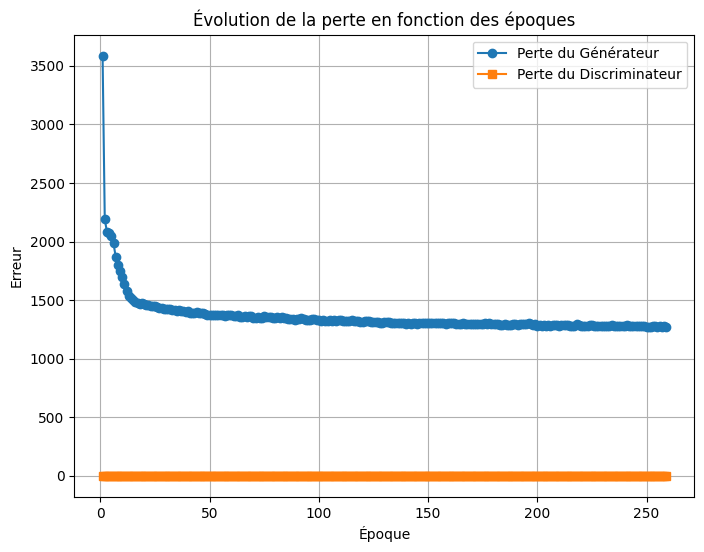

In [4]:
import matplotlib.pyplot as plt

# Fonction pour tracer les courbes de perte
def plot_losses(gen_error, disc_error):
    epochs = range(1, len(gen_error) + 1)  # Création de la liste des époques

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, gen_error, label="Perte du Générateur", marker='o', linestyle='-')
    plt.plot(epochs, disc_error, label="Perte du Discriminateur", marker='s', linestyle='-')

    plt.xlabel("Époque")
    plt.ylabel("Erreur")
    plt.title("Évolution de la perte en fonction des époques")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'appel (une fois que tu as rempli disc_error et gen_error avec le training)
plot_losses(gen_loss, disc_loss)